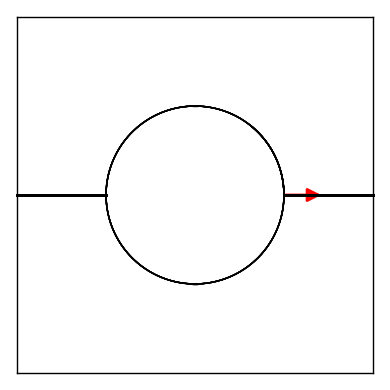

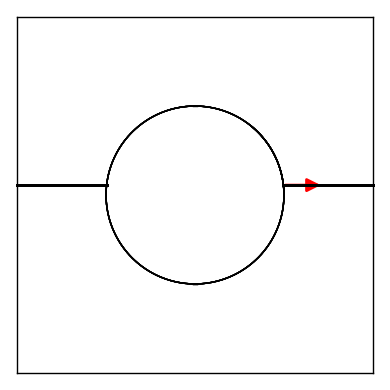

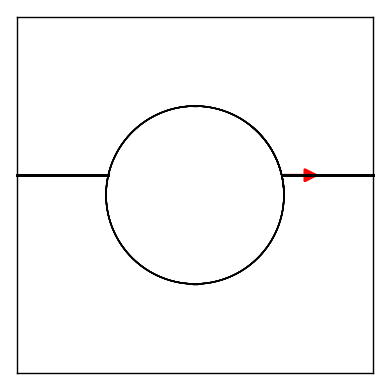

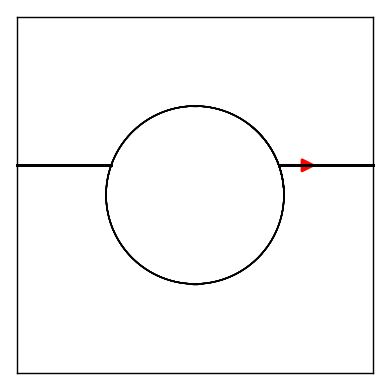

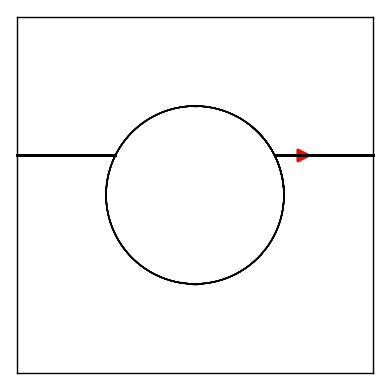

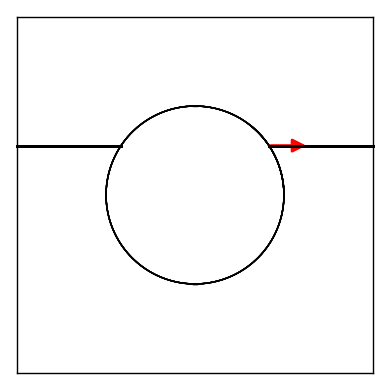

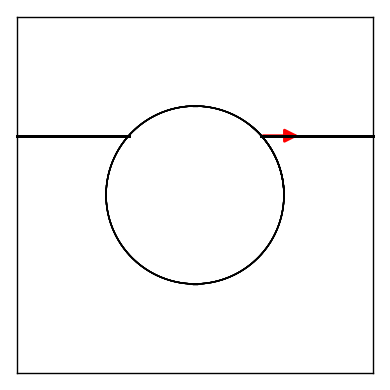

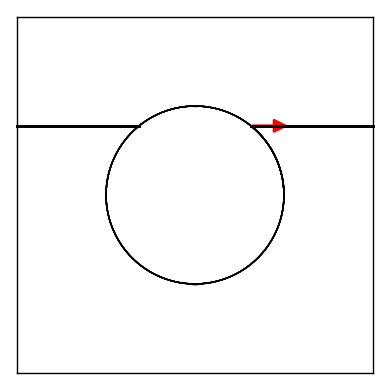

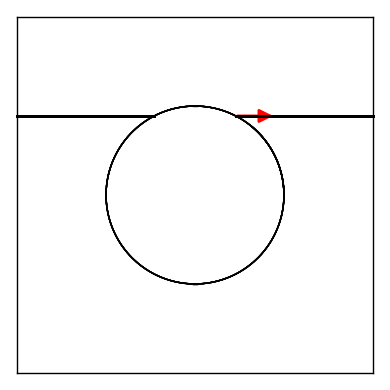

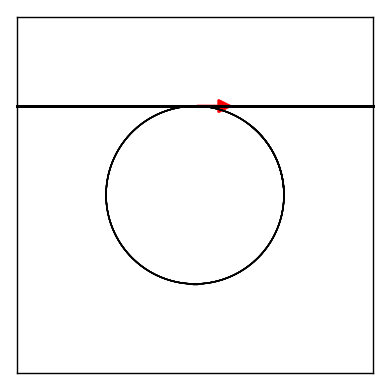

done


In [16]:
# New Billiards 2021 including rolling systems
# A very general billiards program capable of handling specular, no-slip, and rolling billiards

# Imports
import numpy as np
import math
black='black'
res=100
m=1
n=1
large=1000000000

# Constants
eps=0.0000000001
N=50 #Number of collisions
eta=0 #arccos(1/3)/np.pi#0.5 #mass distribution constant
#R=0.01 #particle radius
BorderColor='midnightblue'
BorderThickness=2
TrajCol='magenta'
graph=Graphics()

def create_matrices(p,v):
    P0=matrix(RR,m,n)
    V0=matrix(RR,m,n)
    P1=matrix(RR,m,n)
    V1=matrix(RR,m,n)
    P2=matrix(RR,m,n)
    V2=matrix(RR,m,n)
    for i in range(0,m):
        for j in range(0,n):
            P0[i,j]=p[i][0]
    for i in range(0,m):
        for j in range(0,n):
            P1[i,j]=p[i][1]
    for i in range(0,m):
        for j in range(0,n):
            P2[i,j]=p[i][2]
    for i in range(0,m):
        for j in range(0,n):
            V0[i,j]=v[j][0]
    for i in range(0,m):
        for j in range(0,n):
            V1[i,j]=v[j][1]
    for i in range(0,m):
        for j in range(0,n):
            V2[i,j]=v[j][2]
    return (P0,P1,P2,V0,V1,V2)

# an old rotation matrix
def rot(x):
    return matrix(RR,[[-1,0,0],[0,cos(x),-sin(x)],[0,sin(x),cos(x)]])
a=np.cos(np.pi*eta)
b=np.sin(np.pi*eta)
U=matrix(RR,[[-a,b,0],[b,a,0],[0,0,-1]]) #rough collision with upward normal
S=matrix(RR,[[1,0,0],[0,1,0],[0,0,-1]]) #specular collision with upward normal

# an old path drawer
def Draw_paths(states):
    paths=Graphics()
    #show(X1,X2,Y1,Y2)
    for i in range(0,2*N+1):
        paths+=plot(line([(states[i][1],states[i][2]),(states[i+1][1],states[i+1][2])],color='green', thickness=1))
            
    return paths

# basic functions concerning wall segments
def qb(wall_segment):
    return (wall_segment[0],wall_segment[1])
def qe(wall_segment):
    return (wall_segment[2],wall_segment[3])
def diff(u1,u2):
    return (u2[0]-u1[0],u2[1]-u1[1])
def veclen(u):
    
    return (u[0]^2+u[1]^2)^.5
def innprod(u1,u2):
    return u1[0]*u2[0]+u1[1]*u2[1]

# this returns the (smallest) angle between two vectors
def vecang(u1,u2):
    if innprod(u1,u2)/(veclen(u1)*veclen(u2))>1:
        #print(innprod(u1,u2)/(veclen(u1)*veclen(u2)))
        return 0.000000001
    if innprod(u1,u2)/(veclen(u1)*veclen(u2))<-1:
        #print(innprod(u1,u2)/(veclen(u1)*veclen(u2)))
        return RR(np.pi-.0000001)
        
    return RR(arccos(innprod(u1,u2)/(veclen(u1)*veclen(u2))))

def ub(wall_segment):
    w=(wall_segment[4],wall_segment[5])
    l=veclen(w)
    return (wall_segment[4]/l,wall_segment[5]/l)
# Testing simple functions above:
# show(veclen(diff(qb(easy_walls[1]),qe(easy_walls[1]))))

# normal vector from qb and qe 
def normal(u1,u2):
    w=diff(u1,u2)
    l=veclen(w)
    return (-w[1]/l,w[0]/l)
    
#show(normal(qb(easy_walls[1]),qe(easy_walls[1])))
def curv(u1,u2,u3):
    # u1=qb, u2=qe, u3=ub
    norm=normal(u1,u2)
    return 2*(u3[0]*norm[0]+u3[1]*norm[1])/veclen(diff(u1,u2))
#show(curv(qb(easy_walls[1]),qe(easy_walls[1]),ub(easy_walls[1])))

def ue(u1,u2,u3):
    # u1=qb, u2=qe, u3=ub
    norm=normal(u1,u2)
    l=(2*(u3[0]*norm[0]+u3[1]*norm[1]))
    w=(norm[0]*l,norm[1]*l)
    return diff(w,u3)
#show( ue( qb(easy_walls[1]),qe(easy_walls[1]),ub(easy_walls[1])) )

def theta(u1,u2,u3,u4):
    # qb,qe,ub,ue
    if innprod(diff(u1,u2),u3)>=0:
        return arccos(innprod(u3,u4))
    if innprod(diff(u1,u2),u3)<0:
        return 2*pi-arccos(innprod(u3,u4))
#show(theta(qb(easy_walls[1]), qe(easy_walls[1]), ub(easy_walls[1]), ue(qb(easy_walls[1]),qe(easy_walls[1]),ub(easy_walls[1]))))

def center(u1,u2,u3):
    #qb,qe,ub
    cu=curv(u1,u2,u3)+eps
    return diff((-u3[1]/cu,u3[0]/cu),u1)
#show(center(qb(easy_walls[1]), qe(easy_walls[1]), ub(easy_walls[1])))

def pdistance(u1,u2):
    return ((u1[0]-u2[0])^2+(u1[1]-u2[1])^2)^(1/2)

def getangle(A):
    # return the angle of the vector A relative to the pos x-axis
    if A[0]>=0:
        if A[1]>=0:
            return (arcsin((A[1]-eps)/veclen(A)))
        if A[1]<0:
            return (arcsin((A[1]+eps)/veclen(A)))
    else:
        #print('down here')
        return RR(pi-arcsin((A[1]-eps)/veclen(A)))
    
def circ_or(v,w):
    if v[0]*w[1]-v[1]*w[0]>0:
        #print('counter clockwise')
        return 0
    else:
        #print('clockwise')
        return 1
    
def draw_table(wall_segments):
    #print(len(wall_segments))
    newgraph=Graphics()
    for i in range(0,len(wall_segments)):
        #print('i',i)
        if wall_segments[i][6]==1:
            # draw line
            newgraph+=plot(line([(wall_segments[i][0],wall_segments[i][1]),(wall_segments[i][2],wall_segments[i][3])],color=black))
        else:
            u1=qb(wall_segments[i])
            u2=qe(wall_segments[i])
            u3=ub(wall_segments[i])
            u4=ue(u1,u2,u3)
            #print(u1,u2,u3,u4)
            C=center(u1,u2,u3)
            #print('center',C)
            arc_angle=RR(theta(u1,u2,u3,u4))
            #print('total angle', arc_angle)
            radius=1/abs(curv(u1,u2,u3))
            #print('radius', radius)
            x0=u1[0]
            y0=u1[1]
            startvec=diff(C,u1)
            #print('start vector',startvec)
            alpha=getangle(startvec)
            #print('alpha',alpha)
            for j in range(0,res+1):
                omega=(-1)^(circ_or(u3,diff(u1,u2)))*j/res*arc_angle
                #print(omega)
                #print(alpha)
                #print(radius*cos(alpha+omega),radius*sin(alpha+omega))
                #print(j,alpha+omega)
                x1=radius*cos(alpha+omega)+C[0]
                y1=radius*sin(alpha+omega)+C[1]
                #print(x1,y1)
                L=line([(x0,y0),(x1,y1)],color=black)
                newgraph=newgraph+plot(L)
                x0=x1
                y0=y1
                #show(newgraph)
    #show(newgraph)
    return newgraph


def pointonarc(x,y,wall):
    u1=qb(wall)
    u2=qe(wall)
    u3=ub(wall)
    u4=ue(u1,u2,u3)
    C=center(u1,u2,u3)
    thet=theta(u1,u2,u3,u4)
    v1=diff(C,(x,y))
    v2=diff(C,u1)
    ori=circ_or(diff(C,u1),diff(C,u2))
    #print('ori',ori)
    ang=vecang(v1,v2)
    #print('theta', thet, 'ang',ang)
    if circ_or(v1,v2)==0:
        angdis=2*pi-ang
    else:
        angdis=ang
    if ori==1 and (thet>pi+eps or thet<pi-eps):
        if thet>2*pi-angdis:
            #print('1')
            return True
        if thet<2*pi-angdis:
            return False
    if ori==0 and (thet>pi+eps or thet<pi-eps):
        if thet>angdis:
            #print('2')
            return True
        if thet<angdis:
            return False
    if thet==pi:
        if innprod(v1,u3)>0:
            return True
        else:
            return False
    
def wall_collide(pos,vel,wall):
    #print('in collide')
    # first check if the trajectory intersects the segment for linear boundaries
    # Note: works for only some circles--need better solution
    # It will excluse some legitimate circles if the trajectory passes in and out the arc
    if wall[6]==1:
        v1=diff(pos,(wall[0],wall[1]))
        v2=diff(pos,(wall[2],wall[3]))
        #print(v1,v2,(vel[1],vel[2]))
        #print(vecang((vel[1],vel[2]),v1),vecang((vel[1],vel[2]),v2),vecang(v1,v2))
        #print(vecang((vel[1],vel[2]),v1)+vecang((vel[1],vel[2]),v2))
        angle_difference=vecang((vel[0],vel[1]),v1)+vecang((vel[0],vel[1]),v2)-vecang(v1,v2) #note cannot use vel directly as it is 3D
        #print(angle_difference)
        if angle_difference>0.001:
            #print('does not collide')
            return (0,0,large+1)
    # m2 is the slope of vel, handling infinite case by making it large        
    if vel[0]==0:
            m2=1000000000
    else:
            m2=vel[1]/vel[0]
    if wall[6]==0:
        #print('checking arc')
        u1=qb(wall)
        u2=qe(wall)
        u3=ub(wall)
        C=center(u1,u2,u3)
        radi=pdistance(C,u1)
        #print('radius',radi)
        A=1+m2^2
        B=-2*C[0]+2*m2*(pos[1]-m2*pos[0]-C[1])
        c=C[0]^2+m2^2*pos[0]^2+2*m2*pos[0]*(C[1]-pos[1])+(pos[1]-C[1])^2-radi^2
        x1=(-B+(B^2-4*A*c)^(1/2))/(2*A)
        x2=(-B-(B^2-4*A*c)^(1/2))/(2*A)
        # This handles the cases where the trajectory misses the circle entirely
        if x1.imag()!=0:
            return (0,0,large+1)
        #if x2.real==False:
        #    return (0,0,large+1)
        else:
            y1=pos[1]+m2*(x1-pos[0])
            y2=pos[1]+m2*(x2-pos[0])
            #print('x1,y1,pointonarc(x1,y1,wall)',x1,y1,pointonarc(x1,y1,wall))
            #print('x2,y2,pointonarc(x2,y2,wall)',x2,y2,pointonarc(x2,y2,wall))
            d2=pdistance(pos,(x2,y2))
            d1=pdistance(pos,(x1,y1))
            #print(d1,d2)
            pointon1=pointonarc(x1,y1,wall) and d1>eps
            pointon2=pointonarc(x2,y2,wall) and d2>eps
            if pointon1:
                #print('made it here')
                # to this point there is nothing to prevent the point being the original point
                # also, we need to make such the intersection is in forward time
                #print('here', d1>eps, ((vel[0]>0 and x1-pos[0]>0) or (vel[0]<0 and x1-pos[0]<0)) , d1<d2 or pointon2==False or  (vel[0]<0 and x2-pos[0]>0) or (vel[0]>0 and x2-pos[0]<0) )
                if d1>eps and ((vel[0]>0 and x1-pos[0]>0) or (vel[0]<0 and x1-pos[0]<0)) and (d1<d2 or pointon2==False or (vel[0]<0 and x2-pos[0]>0) or (vel[0]>0 and x2-pos[0]<0)):
                    #print('returning x1')
                    return (x1,y1,d1)
            #print(x2,y2,pointon2)
            if pointon2:
                #print('made it to x2 part')
                #print('d2>eps,d2,eps',d2>eps,d2,eps)
                if d2>eps and ((vel[0]>0 and x2-pos[0]>0) or (vel[0]<0 and x2-pos[0]<0)):
                    #print('returning x2')
                    return (x2,y2,d2)
            #print(x1,y1,d1)
            #print(x2,y2,d2)
        #print('emergency exit')
        return(0,0,large+1)
    if wall[6]==1:
        # find the intersection point 
        if wall[2]==wall[0]:
            m1=(wall[3]-wall[1])/(eps)
        else:
            m1=(wall[3]-wall[1])/(wall[2]-wall[0])
        if m2==m1:
            m2=m2-eps
        x=(m2*pos[0]-pos[1]-m1*wall[0]+wall[1])/(m2-m1)
        y=pos[1]+m2*(x-pos[0])
        if ((x-pos[0])^2+(y-pos[1])^2)<eps:
            #print('not supposed to be here')
            return (0,0,large+1)
        else:
            #print('found a collision')
            return (x,y,((x-pos[0])^2+(y-pos[1])^2))

def next_wall(walls,rotational_position,x,y,rotational_velocity,vx,vy):
    #print('in next wall')
    best_dist=large
    bestx=x
    besty=y
    best_wall=0
    for i in range(0,len(walls)):
        #print('wall', i)
        #note: dist=distance squared
        (xnew,ynew,dist)=wall_collide((x,y),(vx,vy),walls[i])
        #print('dist',dist)
        if eps<dist<best_dist:
            bestx=xnew
            besty=ynew
            best_dist=dist
            best_wall=i
    return ((best_dist/(rotational_velocity^2+vx^2+vy^2)^(1/2))*rotational_velocity+rotational_position,bestx,besty,best_wall)

def new_positions(walls,M0,M1,M2,N0,N1,N2):
    #print('new positions')
    Mw=matrix(ZZ,m,n)
    for i in range(0,m):
        #print(i)
        for j in range(0,n):
            #$print(j)
            #show(M1)
            (M0[i,j],M1[i,j],M2[i,j],Mw[i,j])=next_wall(walls,M0[i,j],M1[i,j],M2[i,j],N0[i,j],N1[i,j],N2[i,j])
        #show(Ptemp)
        #print(M0,M1,M2)
    return (M0,M1,M2,Mw[0,0])

def get_tangent(wall,x,y):
    if wall[6]==1:
        return getangle(diff(qb(wall),qe(wall)))
    if wall[6]==0:
        #print('circ tan')
        u1=qb(wall)
        u2=qe(wall)
        u3=ub(wall)
        C=center(u1,u2,u3)
        perp=getangle(diff(C,(x,y)))
        return perp+pi/2
    else:
        return False

def reflect(wall,x,y,vr,vx,vy):
    V=matrix(RR,3,1)
    V[0,0]=vr
    V[1,0]=vx
    V[2,0]=vy
    #show(V)
    # omega is the angle of the line or tangent to the circle, oriented by the direction
    omega=get_tangent(wall,x,y)
    U1=rot(omega)
    U2=rot(-omega)
    if wall[9]==0:
        #print('here thu')
        #show(U1,U2)
        T=matrix(RR,n,n)
        T=U1*S*U2
        #show(V)
        V=T*V
    else:
        V=rot(omega)*U*rot(-omega)*V
    #show(V)
    return (V[0,0],V[1,0],V[2,0])

def vecsign(x,y,a,b):
    if x*b-y*a>0:
        return 1
    else:
        return -1
        
def getoutnorm(vx,vy,ang):
    if vx*np.cos(ang)+vy*np.sin(ang)>0:
        return (np.cos(ang), np.sin(ang))
    else:
        return (-np.cos(ang), -np.sin(ang))
        

def reflect_2021(wall,x,y,vr,vx,vy):
    wallType = 0
    V=matrix(RR,3,1)
    V[0,0]=vr
    V[1,0]=vx
    V[2,0]=vy
    #show(V)
    # omega is the angle of the line or tangent to the circle, oriented by the direction
    omega=get_tangent(wall,x,y)
    norman=RR(omega-np.pi/2)
    #print(norman)
    en=RR(abs(vx*np.cos(norman)+vy*np.sin(norman)))
    lowen=False
    pot=vecsign(vx,vy,wall[2]-wall[0],wall[3]-wall[1])*wall[10]
    U1=rot(omega)
    U2=rot(-omega)
    if wall[9]==1:
        V=rot(omega)*U*rot(-omega)*V
        wallType = 1
    elif wall[9]==3:
        wallType = 3
        #print('in curveland')
        en=RR(abs(vx*np.cos(norman)+vy*np.sin(norman)))
        if en<pot:
            lowen=True
            #print('low energy')
        else:
            (a,b)=getoutnorm(vx,vy,norman)
            orientation=vecsign(vx,vy,a,b)
            thet1=np.arccos(vx*a+vy*b)
            if abs(np.sin(thet1)/(1-pot)^.5)>1:
                lowen=True
            else: 
                thet2=np.arcsin(np.sin(thet1)/(1-pot)^.5)
            
                ra=orientation*(thet1-thet2)
                V[1,0]=vx*np.cos(ra)-vy*np.sin(ra)
                V[2,0]=vx*np.sin(ra)+vy*np.cos(ra)
        
    elif wall[9]==0 or lowen==True:
        #print()
        wallType = 0
        T=matrix(RR,n,n)
        T=U1*S*U2
        #show(V)
        V=T*V
        
    elif wall[9]==4:
        wallType = 4
    #else:
    #    V=rot(omega)*U*rot(-omega)*V
    #show(V)
    cosphi=RR(V[1,0]*np.cos(omega)+V[2,0]*np.sin(omega))
        
    return (V[0,0],V[1,0],V[2,0],cosphi,wallType)

def new_velocities(walls,P1,P2,V0,V1,V2,Pw):
    for i in range(0,m):
        for j in range(0,n):
            (V0[i,j],V1[i,j],V2[i,j])=reflect(walls[Pw[i,j]],P1[i,j],P2[i,j],V0[i,j],V1[i,j],V2[i,j])
    return (V0,V1,V2)
    
def new_velocities_2021(walls,P1,P2,V0,V1,V2,Pw):
    (V0[0,0],V1[0,0],V2[0,0],cosphi,wallType)=reflect_2021(walls[Pw],P1[0,0],P2[0,0],V0[0,0],V1[0,0],V2[0,0])
    return (V0,V1,V2,cosphi,wallType)

def Draw_paths(X1,Y1,X2,Y2):
    paths=Graphics()
    #show(X1,X2,Y1,Y2)
    for i in range(0,m):
        for j in range(0,n):
            #print((O[i][j][1],O[i][j][2]),(N[i][j][1],N[i][j][2]))
            paths+=plot(line([(X1[i,j],Y1[i,j]),(X2[i,j],Y2[i,j])],color=black))
            #show(paths)
    return paths

# This tests Draw_paths
# P1=[[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]],[[1,1,1],[1,1,1],[1,1,1]]]
# P2=[[[1,2,2],[1,0,0],[1,2,4]],[[1,12,12],[1,12,12],[1,11,1]],[[1,11,1],[1,11,1],[1,11,21]]]
# testgraph=Draw_paths(P1,P2)
# show(testgraph)
# wall_segments is a k by 10 matrix, Renato's 9 plus the tenth: 0=smooth, 1=rough
# N_max is the maximum iterations before stopping
# draw 

def phaseangle(wall,  x,  y,p,q):
    if wall[6]==1:
        return RR(vecang((wall[4],wall[5]),(x,y)))
    if wall[6]==0:
        return RR(vecang((RR(cos(get_tangent(wall,p,q))),RR(sin(get_tangent(wall,p,q)))) ,(x,y)))
        #print(pang)
        #if pang<-pi/2:
        #    return pang+pi
        #else:
        #    return pang

def Billiard(wall_segments, N_max, draw, p, v):
    if draw==1:
        graph=draw_table(wall_segments)
    (P0,P1,P2,V0,V1,V2)=create_matrices(p,v)
    errorcount=0
    for i in range(0,N_max):
        OP1=P1[:]
        OP2=P2[:]
        (P0,P1,P2,Pwall)=new_positions(wall_segments,P0,P1,P2,V0,V1,V2)
        (V0,V1,V2)=new_velocities(wall_segments,P1,P2,V0,V1,V2,Pwall[0,0])
        pathgraph=Draw_paths(OP1,OP2,P1,P2)
        graph=graph+pathgraph
        if OP1==P1 and OP2==P2:
            errorcount+=1
    #print('adjustments',errorcount)
    tempstates=np.array(5)
    
    tempstates=[P0[0,0],P1[0,0],P2[0,0],V0[0,0],V1[0,0],V2[0,0]]
    return (tempstates,Pwall[0,0],graph)

def BilliardMapIteration(wall_segments, p, v):
    stoperror=False
    (P0,P1,P2,V0,V1,V2)=create_matrices(p,v)
    OP1=P1[:]
    OP2=P2[:]
    (P0,P1,P2,Pwall)=new_positions(wall_segments,P0,P1,P2,V0,V1,V2)
    (V0,V1,V2,cosphi,wallType)=new_velocities_2021(wall_segments,P1,P2,V0,V1,V2,Pwall)
    #print(V0,V1,V2)
    pathgraph=Draw_paths(OP1,OP2,P1,P2)
    
    if OP1==P1 and OP2==P2:
        stoperror=True
    
    if wallType == 4:
        if (Pwall == 7) or (Pwall == 9):
            P1[0,0] = -P1[0,0]
        else:
            P2[0,0] = -P2[0,0]
    
    return ([P0[0,0],P1[0,0],P2[0,0],V0[0,0],V1[0,0],V2[0,0]],Pwall,pathgraph,stoperror,cosphi)

#def ngon(n): 
#    tab=[[1,0,RR(cos(2*pi/n)),RR(sin(2*pi/n)),RR(-cos((n-2)/(2*n))),RR(sin((n-2)/(2*n))),1,0,1,0,-1]]
#    for i in range(1,n):
#        tab+=[[RR(cos(i*2*pi/n)),RR(sin(i*2*pi/n)),RR(cos((i+1)*2*pi/n)),RR(sin((i+1)*2*pi/n)),RR(cos((i+1)*2*pi/n)-cos(i*2*pi/n)),RR(sin((i+1)*2*pi/n)-sin(i*2*pi/n)),1,0,1,0,-1]]
#    return tab
    
def ngonthrshift(n,th): #n=number of sides, inscribed circle of radius 1+th
    tab=[[RR((1+th)*cos(pi/n)),RR(-(1+th)*sin(pi/n)),RR((1+th)*cos(pi/n)),RR((1+th)*sin(pi/n)),1,2]]
    for i in range(1,n):
        tab+=[[RR((1+th)*cos(i*2*pi/n-pi/n)), RR((1+th)*sin(i*2*pi/n-pi/n)),RR((1+th)*cos((i+1)*2*pi/n-pi/n)),RR((1+th)*sin((i+1)*2*pi/n-pi/n)),1,2]]
    return tab




# Billiard updating routines
def Free(state):
    st=state.copy()
    
    newx=0
    newy=0
    # line of motion
    x0=state[1]
    y0=state[2]    
    vx=state[4]
    vy=state[5]
    curwall=st[10]
    if vx==0:
        vx=eps
    for i in range(0,len(table)):
        
        if i!=curwall: #Don't check the current wall
            #print(i,curwall,'now')
            a=table[i][0]
            b=table[i][1]
            c=table[i][2]
            d=table[i][3]
            if c==a:
                a=a+eps
            if b==d:
                b=b+eps
            if sign((a-x0)*vy-(b-y0)*vx)!=sign((c-x0)*vy-(d-y0)*vx):
                
                st[10]=i #reset current wall
                st[1]=(c*(d-b)/(c-a)+y0-vy*x0/vx-d)/((d-b)/(c-a)-vy/vx) #new x value
                st[2]=d+(d-b)/(c-a)*(st[1]-c)
                st[7]=state[7]+((st[1]-x0)^2+(st[2]-y0)^2)^.5/(vx^2+vy^2)^.5 #adjust time 
       
            
    
    return(st)

def veclen(u):
    return (u[0]^2+u[1]^2)^.5

def getangle(A):
    # return the angle of the vector A relative to the pos x-axis
    if A[0]>=0:
        if A[1]>=0:
            return (arcsin((A[1]-eps)/veclen(A)))
        if A[1]<0:
            return (arcsin((A[1]+eps)/veclen(A)))
    else:
        
        return RR(pi-arcsin((A[1]-eps)/veclen(A)))

    
def Roll(state,iter):
    st=state.copy()
    V=matrix(RR,3,1)
    Vtem=matrix(RR,3,1)
    V[0,0]=st[3]#*(-1)^st[6]
    spin=V[0,0]
    st[6]=1-st[6] #0=top sheet, 1=bottom sheet
    wall=table[int(st[10])]
    aa=wall[2]-wall[0]
    bb=wall[3]-wall[1]
    omega=getangle((aa,bb))
    # print(st[10],'omega',omega)
    U1=rot(omega)
    U2=rot(-omega)

    V[1,0]=st[4]
    V[2,0]=st[5]
    Vtem=rot(-omega)*V
    ue=Vtem[1,0]
    un=Vtem[2,0]
    #print(RR(eta*abs(un)))
    D=R/(eta*abs(un))*((1-np.cos(np.pi*eta))*spin+np.sin(np.pi*eta)*ue)*(-1)^st[6]
    #print(iter,RR(D),st[10])
    V=rot(omega)*U*rot(-omega)*V
    #print('Vtem',Vtem,'V',V)
    st[3]=V[0,0]
    st[4]=V[1,0]
    st[5]=V[2,0]
    mag=np.sqrt(aa^2+bb^2)
    #print((st[1],st[2]),(st[1]+D*aa/mag,
    st[1]=st[1]+D*aa/mag
    st[2]=st[2]+D*bb/mag
    return(st)


def arcpart(rad, positions,epsilon):
    xyPhilist = [[],[],[]]
    
    for ycirc in np.linspace(0,rad-0.00001,positions):
        xcirc = (rad**2-ycirc**2)**(0.5)
        if (xcirc != 0):
            Phi = np.arctan(ycirc/xcirc)
        else:
            Phi = np.pi/4
        xcirc += epsilon
        xyPhilist[0].append(xcirc)
        xyPhilist[1].append(ycirc)
        xyPhilist[2].append(Phi)
    return xyPhilist

def gamma(Eta):
    GAMMA = ((1-cos(np.pi*Eta))**0.5)/((np.cos(np.pi*Eta)+1)**0.5)
    return GAMMA

def make_mooncusp(r,n):
    tab=[[1,0,RR(cos(2*pi/n)),RR(sin(2*pi/n)),0,1,0,0,0,1,0]]
    for i in range(1,n):
        tab+=[[RR(cos(i*2*pi/n)),RR(sin(i*2*pi/n)),RR(cos((i+1)*2*pi/n)),RR(sin((i+1)*2*pi/n)),RR(sin(i*2*pi/n)),-RR(cos(i*2*pi/n)),0,0,0,1,0]]
#     tab+=[[1,0,1-r+RR(r*cos(2*pi/n)),RR(r*sin(2*pi/n)),0,1,0,0,0,1,0]]
#     for i in range(1,n):
#         tab+=[[1-r+RR(r*cos(i*2*pi/n)),RR(r*sin(i*2*pi/n)),RR(1-r+r*cos((i+1)*2*pi/n)),RR(r*sin((i+1)*2*pi/n)),RR(sin(i*2*pi/n)),-RR(cos(i*2*pi/n)),0,0,0,1,0]]
        
    return tab

def make_sinay(r,n,bval):
    tab=[[r,0,RR(r*cos(2*pi/n)),RR(r*sin(2*pi/n)),0,1,0,0,0,1,0]]
    for i in range(1,n):
        tab+=[[RR(r*cos(i*2*pi/n)),RR(r*sin(i*2*pi/n)),RR(r*cos((i+1)*2*pi/n)),RR(r*sin((i+1)*2*pi/n)),RR(r*sin(i*2*pi/n)),-RR(r*cos(i*2*pi/n)),0,0,0,1,0]]
    if bval:
        tab += [[1,-1,1,1,0,1,1,0,0,4,0]]
        tab += [[1,1,-1,1,-1,0,1,0,0,4,0]]
        tab += [[-1,1,-1,-1,0,-1,1,0,0,4,0]]
        tab += [[-1,-1,1,-1,1,0,1,0,0,4,0]]
    else:
        tab += [[1,-1,1,1,0,1,1,0,0,1,0]]
        tab += [[1,1,-1,1,-1,0,1,0,0,1,0]]
        tab += [[-1,1,-1,-1,0,-1,1,0,0,1,0]]
        tab += [[-1,-1,1,-1,1,0,1,0,0,1,0]]
    
    return tab



# TABLES
# 
# Tables are lists of walls oriented counterclockwise
# Each wall is a list 
# [{0}starting x, 
# {1} starting y, 
# {2} ending x, 
# {3} ending y, 
# {4} direction vector x, 
# {5} direction vector y, 
# {6} shape: 0=arc 1=line,
# {7}  0=not end 1=end,
# {8}  gamma
# {9} collision type: 0=specular 1=no-slip 2=rolling 3=lens 4 = torus , #phasing out specular
# {10} potential change left to right] #maybe move to share gamma





#tablegraph.show(axes=False, aspect_ratio=1)

# States
# 
# States has N+1 (pairs of, for rolling) rows, each row being the state after collision m (before and after rolling) 
# Each state has eleven components 
#[{0} rotational position (seldom used), 
# {1} x pos in fixed frame, 
# {2} y pos in fixed frame, 
# {3} rotational velocity (not used for specular collisions), 
# {4} x velocity, 
# {5} y velocity, 
# {6} t=time, 
# {7} s=arclength, 
# {8} phi=angle relative to outward normal, 
# {9} wall number] 
# 



M=10 # dimension of state, saved as a constant to more easily change

################################################################################
############################### Interactive ####################################
N=150 #number of collisions for each orbit, including passing through the lens wall
startang=0
xypoints = 10
spin=0
R=0.5
eta= 0.7 #arccos(1/3)/np.pi #0.5 #mass distribution constant
x0 = 0.9
y0= -0.9
################################################################################
################################################################################
epsilon = 0.01


a=np.cos(np.pi*eta)
b=np.sin(np.pi*eta)
U=matrix(RR,[[-a,b,0],[b,a,0],[0,0,-1]]) #rough collision with upward normal
S=matrix(RR,[[1,0,0],[0,1,0],[0,0,-1]]) #specular collision with upward normal

table=make_sinay(R,7,True)
xyPhilist = arcpart(R,xypoints,epsilon)

graph=Graphics()
graph=draw_table(table)
new = graph
states=np.zeros(shape=(N,M)) #new states array for each orbit

for x0,y0,Phi in zip(xyPhilist[0],xyPhilist[1],xyPhilist[2]):
    vx0=RR(np.cos(startang))
    vy0=RR(np.sin(startang))
    w0=vx0*(-np.sin(Phi)/gamma(eta))
    norm = (vx0**2+vy0**2+w0**2)**0.5
    states[0]=[0,x0,y0,w0/norm,vx0/norm,vy0/norm,0,RR(np.pi),startang,(n+1)/2] 



    for i in range(0,N-1):
        (states[i+1,0:6],states[i+1,9],newtraj,runerror,cosphi)=BilliardMapIteration(table, [states[i,0:3]], [states[i,3:6]])
        states[i+1,8]=cosphi
        graph+=newtraj

    graph+=arrow((x0,y0), (x0+.2*RR(cos(startang)),y0+.2*RR(sin(startang))) ,color='red',width=2,zorder=2,arrowsize=4)
    graph.show(axes=False, aspect_ratio=True)
#     graph.save('sinay'+'('+str(round(R,2))+','+str(round(eta,3))+')_spin'+str(round(w0,3))+'.eps', axes=False, transparent=True, aspect_ratio=1)
    graph=new

    #phasegraph.show(axes=False)






print('done')

In [30]:
print(np.linspace(0,0.5,8))

[0.         0.07142857 0.14285714 0.21428571 0.28571429 0.35714286
 0.42857143 0.5       ]
